# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for AdvXResNet
from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
__version__

'1.0.55.dev0'

# 6D image test

In [4]:
class Image6D(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor):
        self._px = px
        self._logit_px=None
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}

    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()

In [5]:
def open_image_6D(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6D,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
            
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x)

In [6]:
#PATH_trunc = 'train/HEPG2-01/Plate1/B02_s1' # path is missing suffix "_w1.png"
#open_image_6D(PATH_trunc)

# Dataset setup

In [7]:
class ImageList6D(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6D(fn, convert_mode=self.convert_mode, after_open=self.after_open)

## Full dataset

### Dataset parameters full dataset

In [8]:
df = pd.read_csv('df_full_dataset.csv', index_col=0)

In [9]:
df.head()

,path,experiment,sirna,multi,valid
0,HEPG2-01/Plate1/B03_s1,HEPG2-01,513,HEPG2-01 513,0
1,HEPG2-01/Plate1/B04_s1,HEPG2-01,840,HEPG2-01 840,0
2,HEPG2-01/Plate1/B05_s1,HEPG2-01,1020,HEPG2-01 1020,0
3,HEPG2-01/Plate1/B06_s1,HEPG2-01,254,HEPG2-01 254,0
4,HEPG2-01/Plate1/B07_s1,HEPG2-01,144,HEPG2-01 144,0


In [10]:
df_subset = pd.concat([df.loc[df.sirna == i].head(2) for i in range(1108+1)], ignore_index=True)

In [11]:
df_subset.loc[::2,'valid'] = 1

In [12]:
df_subset.tail(1)

,path,experiment,sirna,multi,valid
2215,HEPG2-02/Plate4/I07_s1,HEPG2-02,1107,HEPG2-02 1107,0


In [13]:
df_orig = pd.read_csv('train.csv')#, index_col=0)

In [14]:
df_orig.head()

,id_code,experiment,plate,well,sirna
0,HEPG2-01_1_B03,HEPG2-01,1,B03,513
1,HEPG2-01_1_B04,HEPG2-01,1,B04,840
2,HEPG2-01_1_B05,HEPG2-01,1,B05,1020
3,HEPG2-01_1_B06,HEPG2-01,1,B06,254
4,HEPG2-01_1_B07,HEPG2-01,1,B07,144


In [15]:
df_orig[df_orig.id_code == 'HEPG2-01_4_J09'] # HEPG2-01/Plate4/J09_s1

,id_code,experiment,plate,well,sirna
992,HEPG2-01_4_J09,HEPG2-01,4,J09,0


In [16]:
df_orig[df_orig.id_code == 'HEPG2-02_4_I07'] # HEPG2-02/Plate4/I07_s1

,id_code,experiment,plate,well,sirna
2075,HEPG2-02_4_I07,HEPG2-02,4,I07,1107


In [17]:
#df.sample(280)

In [18]:
## XResNet34
#sz = 512
#sz = 256
sz = 128

In [19]:
## XResNet34
#bs = 8*14   #  256 --> 7916MiB /  7952MiB
#bs = 8*14//4 #  512 --> 7909MiB /  7952MiB
bs = 64

In [20]:
sz, bs

(128, 64)

### Basic full dataset

In [21]:
tfms = get_transforms()

In [22]:
data = (ImageList6D.from_df(df_subset, path='train') # SET CORRECT DF!!! df.sample(280), df_subset
        .split_from_df(col=-1) #.split_by_rand_pct(seed=42) # 
        .label_from_df(cols=-3) #, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .transform(tfms, size=sz) # !!!
        .databunch(bs=bs))

In [23]:
data

ImageDataBunch;

Train: LabelList (1108 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
0,1,2,3,4
Path: train;

Valid: LabelList (1108 items)
x: ImageList6D
Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128),Image6D (6, 128, 128)
y: CategoryList
0,1,2,3,4
Path: train;

Test: None

In [24]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [25]:
data.batch_size

64

In [26]:
data.train_ds[0]

(Image6D (6, 128, 128), Category 0)

In [27]:
#data.classes

In [28]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 0, 0)

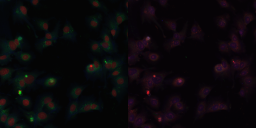

In [29]:
data.train_ds[0][0]

### Adversarial full dataset

In [19]:
data_a = (ImageList6D.from_df(df, path='train') # SET CORRECT DF!!!
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-2, label_delim=' ') # label_delim=' ' for MultiCategoryList !
        .transform(size=sz)
        .databunch(bs=bs))

In [20]:
data_a

ImageDataBunch;

Train: LabelList (33191 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: MultiCategoryList
HEPG2-01;513,HEPG2-01;840,HEPG2-01;1020,HEPG2-01;254,HEPG2-01;144
Path: train;

Valid: LabelList (3324 items)
x: ImageList6D
Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256),Image6D (6, 256, 256)
y: MultiCategoryList
267,768,632,86,1051
Path: train;

Test: None

In [21]:
data_a.c, len(data_a.classes), data_a.classes[-5:]

(1138, 1138, ['RPE-03', 'RPE-04', 'RPE-05', 'RPE-06', 'RPE-07'])

In [28]:
#learn_a.data.classes[:1108]

In [29]:
learn_a.data.classes[1107]

NameError: name 'learn_a' is not defined

In [176]:
learn_a.data.classes[1107:1111]

['997', '998', '999', 'HEPG2-01', 'HEPG2-02', 'HEPG2-03']

In [174]:
learn_a.data.classes[1108:]

['HEPG2-01',
 'HEPG2-02',
 'HEPG2-03',
 'HEPG2-04',
 'HEPG2-05',
 'HEPG2-06',
 'HEPG2-07',
 'HUVEC-01',
 'HUVEC-02',
 'HUVEC-03',
 'HUVEC-04',
 'HUVEC-05',
 'HUVEC-06',
 'HUVEC-07',
 'HUVEC-08',
 'HUVEC-09',
 'HUVEC-10',
 'HUVEC-11',
 'HUVEC-12',
 'HUVEC-13',
 'HUVEC-14',
 'HUVEC-15',
 'HUVEC-16',
 'RPE-01',
 'RPE-02',
 'RPE-03',
 'RPE-04',
 'RPE-05',
 'RPE-06',
 'RPE-07']

In [22]:
data_a.batch_size

128

In [23]:
data_a.train_ds[0]

(Image6D (6, 256, 256), MultiCategory HEPG2-01;513)

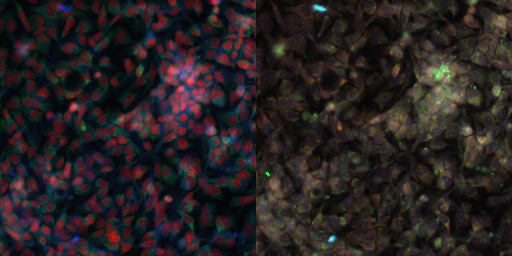

In [24]:
data_a.train_ds[0][0]

# Model setup

## XResNet setup

### XResNet34

In [99]:
xresnet34c = XResNet(1, [3,4,6 ,3], c_in=6, c_out=1108) #XResNet34!

In [100]:
#xresnet34c

In [101]:
xresnet34c(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 1108])

In [102]:
xresnet34c(data.train_ds[0][0].data.unsqueeze(0)).shape

torch.Size([1, 1108])

# MNIST test

In [25]:
path = untar_data(URLs.MNIST_SAMPLE)

In [26]:
data = ImageDataBunch.from_folder(path)

In [27]:
xresnet34c_mnist = XResNet(1, [3,4,6 ,3], c_in=3, c_out=2)

In [28]:
#xresnet34c_mnist

In [39]:
#models.resnet18()

In [ ]:
#learn = cnn_learner(data, models.resnet18, metrics=accuracy)

In [29]:
learn = Learner(data, xresnet34c_mnist, metrics=accuracy)

In [30]:
#learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-04
Min loss divided by 10: 7.59E-02


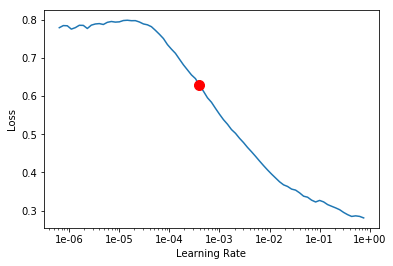

In [31]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [32]:
learn.fit_one_cycle(8, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.049546,0.014727,0.993131,00:06
1,0.015395,0.010910,0.997547,00:06
2,0.014550,0.011650,0.997056,00:06
3,0.008053,0.088613,0.967615,00:06
4,0.003818,0.009606,0.997056,00:06
5,0.001422,0.002616,0.999019,00:06
6,0.000402,0.000585,1.000000,00:06
7,0.000095,0.000692,1.000000,00:06


# Full training

## Training XResNet34

In [103]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [104]:
learn = Learner(data, xresnet34c, metrics=[accuracy], callback_fns=[CSVLogger])

In [105]:
redlr = ReduceLROnPlateauCallback(learn, monitor='valid_loss',patience = 2)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', name='rcic_multicat_v6_resnet34_baseline_randomshuffle_best_512')

In [106]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### Training with data augmentation

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02
Min loss divided by 10: 3.02E-02


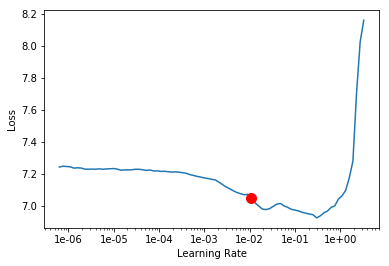

In [107]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [108]:
learn.fit_one_cycle(4, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,7.727986,7.443002,0.000000,00:19
1,7.380239,13.765330,0.001805,00:19
2,7.129729,7.412708,0.001805,00:19
3,6.875668,7.340404,0.001805,00:19


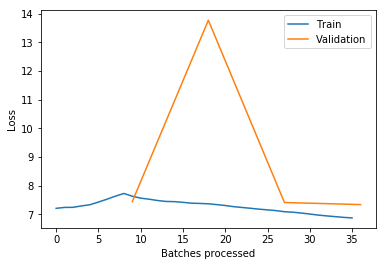

In [109]:
learn.recorder.plot_losses()

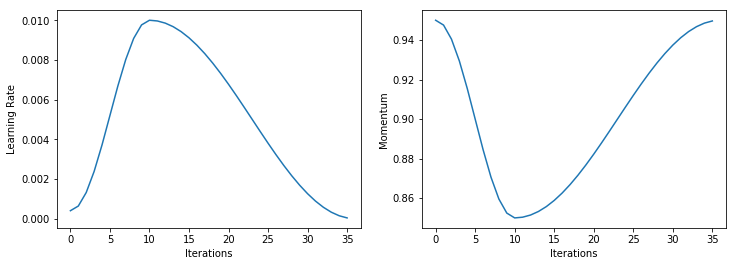

In [110]:
learn.recorder.plot_lr(show_moms=True)

In [111]:
learn.fit_one_cycle(12, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.264269,7.507554,0.002708,00:19
1,6.185112,8.511067,0.000903,00:18
2,6.116804,10.827265,0.002708,00:19
3,6.041699,11.222934,0.003610,00:19
4,5.907817,13.394567,0.003610,00:19
5,5.765768,13.420794,0.002708,00:19
6,5.568363,12.407326,0.001805,00:19
7,5.352516,12.570496,0.003610,00:19
8,5.111619,12.327188,0.001805,00:19
9,4.850553,13.266662,0.003610,00:19


In [112]:
learn.fit_one_cycle(12, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.406614,14.177512,0.003610,00:19
1,3.440503,15.713040,0.001805,00:19
2,3.570685,18.461338,0.002708,00:18
3,3.805930,28.999952,0.003610,00:19
4,3.915442,17.885668,0.000903,00:19
5,3.830156,15.536905,0.008123,00:19
6,3.621099,17.007982,0.003610,00:19
7,3.363411,18.305189,0.004513,00:19
8,3.057379,20.856947,0.004513,00:19
9,2.766117,23.189913,0.003610,00:19


In [113]:
learn.fit_one_cycle(12, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.187099,24.193558,0.003610,00:19
1,1.223053,26.334412,0.002708,00:19
2,1.436939,32.404392,0.004513,00:19
3,1.798605,31.490015,0.004513,00:19
4,1.992221,25.234480,0.002708,00:19
5,2.004390,26.003298,0.008123,00:19
6,1.924004,30.850554,0.004513,00:19
7,1.741820,28.609756,0.004513,00:19
8,1.543220,27.468130,0.005415,00:19
9,1.342865,30.278337,0.005415,00:19


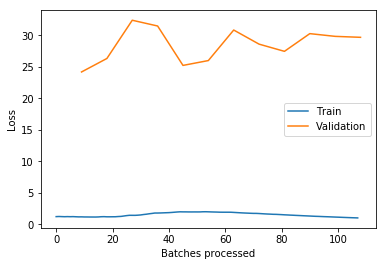

In [114]:
learn.recorder.plot_losses()

In [115]:
learn.fit_one_cycle(12, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.369654,29.823866,0.003610,00:19
1,0.371130,29.968285,0.002708,00:19
2,0.357383,30.229429,0.002708,00:19
3,0.341992,30.764341,0.003610,00:19
4,0.333913,30.605751,0.003610,00:19
5,0.313116,31.423380,0.003610,00:19
6,0.310139,30.732725,0.003610,00:19
7,0.298534,31.314798,0.003610,00:19
8,0.290570,31.677769,0.002708,00:19
9,0.279278,31.588219,0.002708,00:19


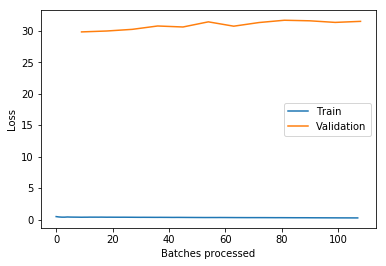

In [116]:
learn.recorder.plot_losses()

In [29]:
learn.save('full_256x256_xresnet34c_tfms_shuffle_e004_20190707', return_path=True)

PosixPath('train/models/full_256x256_xresnet34c_tfms_shuffle_e004_20190707.pth')

In [52]:
learn.load('full_256x256_xresnet34c_tfms_shuffle_e004_20190707');

In [54]:
learn.fit_one_cycle(1, max_lr=1e-1, callbacks=[redlr, savem])

epoch,train_loss,valid_loss,accuracy,time
0,7.070996,7.058782,0.000274,04:22


Better model found at epoch 0 with accuracy value: 0.00027386005967855453.


In [55]:
learn.fit_one_cycle(80, max_lr=1e-1, callbacks=[redlr, savem])

epoch,train_loss,valid_loss,accuracy,time
0,7.023948,7.051001,0.000274,04:22
1,7.021206,7.047033,0.000274,04:23
2,7.021367,7.045703,0.000274,04:22
3,7.024875,7.045263,0.000137,04:22
4,7.028161,7.046431,0.000137,04:22
5,7.034610,7.049460,0.000137,04:23
6,7.037644,7.048342,0.000548,04:23
7,7.041547,7.052210,0.000411,04:22
8,7.050994,7.049976,0.000685,04:24
9,7.052773,7.056079,0.000822,04:22


Better model found at epoch 0 with accuracy value: 0.00027386005967855453.
Epoch 6: reducing lr to 0.004555890281516284
Better model found at epoch 6 with accuracy value: 0.0005477201193571091.
Better model found at epoch 8 with accuracy value: 0.0006846501491963863.
Epoch 9: reducing lr to 0.007915337167015802
Better model found at epoch 9 with accuracy value: 0.0008215801790356636.
Epoch 12: reducing lr to 0.011653051445312495
Better model found at epoch 12 with accuracy value: 0.0010954402387142181.
Epoch 15: reducing lr to 0.0152
Epoch 18: reducing lr to 0.018016192066795857
Epoch 21: reducing lr to 0.019672887932375056
Epoch 24: reducing lr to 0.019984268213105567
Epoch 27: reducing lr to 0.01974928012470175
Epoch 30: reducing lr to 0.01923879836993157
Epoch 33: reducing lr to 0.018467248123314874
Epoch 36: reducing lr to 0.01745643182314506
Epoch 39: reducing lr to 0.016234913078995262
Better model found at epoch 40 with accuracy value: 0.00150623032823205.
Epoch 42: reducing lr 

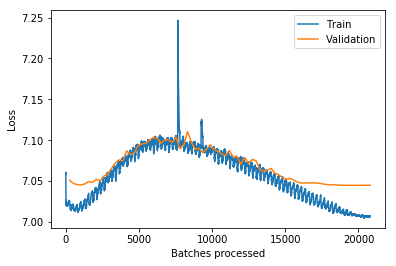

In [56]:
learn.recorder.plot_losses()

### Reload weights with highest accuracy and train with 512px

In [83]:
learn.load('rcic_multicat_v6_resnet34_baseline_randomshuffle_best');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-06
Min loss divided by 10: 6.31E-08


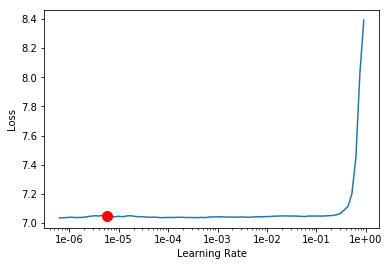

In [80]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [84]:
learn.fit_one_cycle(4, max_lr=1e-2, callbacks=[redlr, savem])

epoch,train_loss,valid_loss,accuracy,time
0,7.038319,7.059025,0.000411,13:41
1,7.040198,7.051106,0.000274,13:43
2,7.035420,7.049069,0.000137,13:43
3,7.014856,7.049101,0.000274,13:43


Better model found at epoch 0 with accuracy value: 0.0004107900895178318.


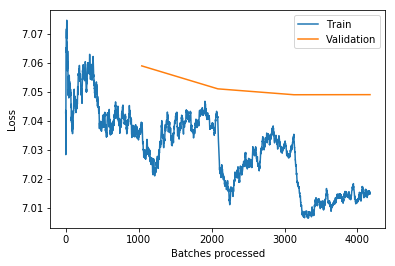

In [85]:
learn.recorder.plot_losses()

In [86]:
learn.save('full_xresnet34c_tfms_shuffle_256e080-512e4_20190708', return_path=True)

PosixPath('train/models/full_xresnet34c_tfms_shuffle_256e080-512e4_20190708.pth')

In [87]:
learn.load('full_xresnet34c_tfms_shuffle_256e080-512e4_20190708');

In [92]:
learn.fit_one_cycle(4, max_lr=1e-2, callbacks=[redlr, savem])

epoch,train_loss,valid_loss,accuracy,time
0,7.035796,7.053763,0.000548,13:39
1,7.043798,7.051091,0.000137,14:13


Better model found at epoch 0 with accuracy value: 0.0005477201193571091.


Traceback (most recent call last):
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/mmp/anaconda3/envs/fastai-dev/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('full_xresnet34c_tfms_shuffle_256e080-512e8_20190708', return_path=True)

In [ ]:
learn.load('full_xresnet34c_tfms_shuffle_256e080-512e8_20190708');

# Schedule domain reversal layer

In [ ]:
# https://docs.fast.ai/callbacks.general_sched.html

In [ ]:
def fit_sgd_warm(learn, n_cycles, lr, mom, cycle_len, cycle_mult):
    n = len(learn.data.train_dl)
    phases = [(TrainingPhase(n * (cycle_len * cycle_mult**i))
                 .schedule_hp('lr', lr, anneal=annealing_cos)
                 .schedule_hp('mom', mom)) for i in range(n_cycles)]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    if cycle_mult != 1:
        total_epochs = int(cycle_len * (1 - (cycle_mult)**n_cycles)/(1-cycle_mult)) 
    else: total_epochs = n_cycles * cycle_len
    learn.fit(total_epochs)

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)
data = ImageDataBunch.from_folder(path)
learn = Learner(data, simple_cnn((3,16,16,2)), metrics=accuracy)
fit_sgd_warm(learn, 3, 1e-3, 0.9, 1, 2)

## Training DenseNet121

In [30]:
import torchvision

In [31]:
class DensNet(nn.Module):
    def __init__(self, num_classes=1000, num_channels=6):
        super().__init__()
        preloaded = torchvision.models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)
        self.classifier = nn.Linear(1024, num_classes, bias=True)
        del preloaded
        
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [32]:
classes = 1108
densenet121c = DensNet(num_classes=classes)

In [33]:
learn = Learner(data, densenet121c, metrics=[accuracy])#, callback_fns=[CSVLogger])

In [34]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

### Training with data augmentation

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-03
Min loss divided by 10: 3.02E-04


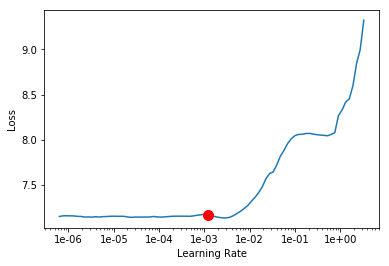

In [35]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [36]:
learn.fit_one_cycle(4, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,7.199771,7.515625,0.000903,00:12
1,7.162681,8.306269,0.000000,00:12
2,7.107798,7.177280,0.000000,00:12
3,7.052804,7.117550,0.000903,00:12


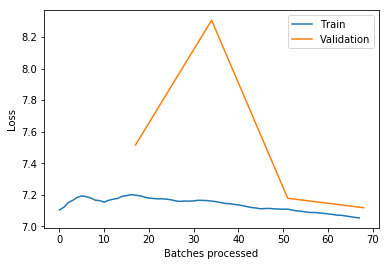

In [37]:
learn.recorder.plot_losses()

In [38]:
learn.fit_one_cycle(12, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,6.963657,7.111160,0.000000,00:12
1,6.942054,7.080187,0.000903,00:12
2,6.925722,7.082076,0.001805,00:12
3,6.898918,7.051175,0.002708,00:12
4,6.842926,7.061873,0.001805,00:12
5,6.770017,7.035374,0.003610,00:12
6,6.689181,7.072708,0.000903,00:12
7,6.601179,7.065923,0.001805,00:12
8,6.515500,7.072819,0.001805,00:12
9,6.440802,7.061987,0.001805,00:12


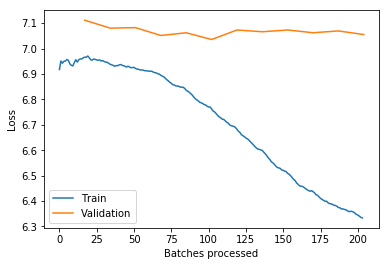

In [39]:
learn.recorder.plot_losses()

In [40]:
learn.fit_one_cycle(12, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,6.214775,7.066750,0.003610,00:12
1,6.207813,7.071788,0.005415,00:12
2,6.191709,7.132222,0.004513,00:12
3,6.148706,7.071136,0.000903,00:12
4,6.076993,7.127541,0.004513,00:12
5,5.987672,7.082487,0.007220,00:12
6,5.880579,7.152024,0.004513,00:12
7,5.767522,7.145583,0.003610,00:12
8,5.667289,7.149451,0.007220,00:12
9,5.572524,7.173132,0.008123,00:12


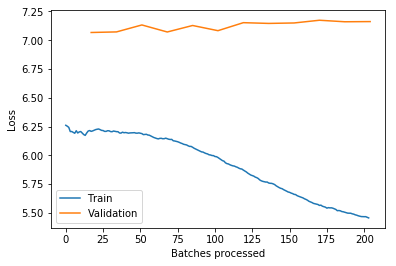

In [41]:
learn.recorder.plot_losses()

In [42]:
learn.fit_one_cycle(12, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,5.329463,7.171751,0.007220,00:12
1,5.307878,7.173186,0.007220,00:12
2,5.280164,7.128494,0.007220,00:12
3,5.219765,7.152465,0.006318,00:12
4,5.144448,7.189916,0.006318,00:12
5,5.035190,7.331117,0.009025,00:12
6,4.903388,7.335598,0.009025,00:12
7,4.764071,7.276896,0.008123,00:12
8,4.651581,7.357907,0.009928,00:12
9,4.558624,7.334327,0.006318,00:12


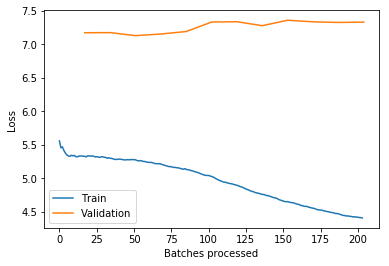

In [43]:
learn.recorder.plot_losses()

In [44]:
learn.fit_one_cycle(12, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,4.238046,7.314677,0.009025,00:12
1,4.225079,7.325913,0.008123,00:12
2,4.191630,7.210022,0.008123,00:12
3,4.164508,7.502226,0.006318,00:12
4,4.055869,7.388776,0.009025,00:12
5,3.949398,7.364982,0.008123,00:12
6,3.818845,7.376920,0.004513,00:12
7,3.681438,7.407080,0.004513,00:12
8,3.546703,7.487301,0.004513,00:12
9,3.426386,7.459539,0.005415,00:12


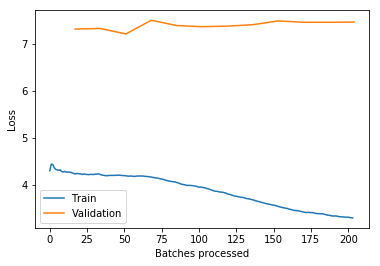

In [45]:
learn.recorder.plot_losses()

# Test predict

# Test submission